Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# Store buckets

___
### Palco 2010

In [3]:
# importa dataset 'palco playlists'
data = pd.read_csv("../datasets/palco_2010.tsv","\t")

In [4]:
# Necessary Preprocess - create date from timestamp
data['date'] = data['timestamp'].apply(lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d') )
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['date'] = data[['year', 'month']].apply(lambda x: datetime.strptime( str(x[0])+'/'+str(x[1]), '%Y/%m' ) , axis=1)

#### Evaluating Time defined Buckets 

How many interactions occur in each month?

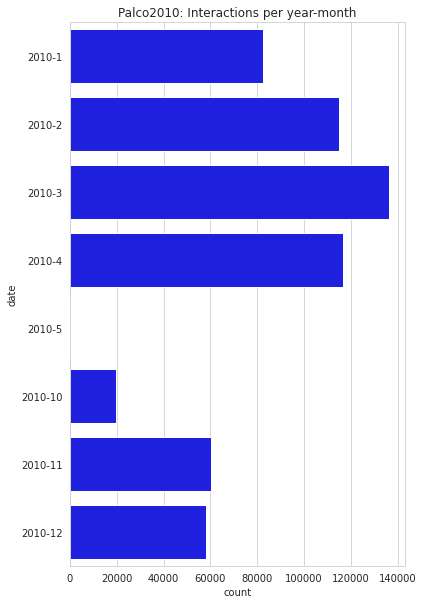

In [5]:
plot_interactions_per_month(data=data, dataset_name='Palco2010')

What is the user presence distribution based on month, quarter, and semester?

In [6]:
user_presence_df, user_month_interactions, trimestres, user_trimestre_interactions, semestres, user_semestre_interactions = get_interactions_info(data=data, user_col='user_id')

In [7]:
user_presence_df.head()

,UserID,month_%,trimestre_%,semestre_%
0,1234,1.0,0.75,1.0
1,163,1.0,0.75,1.0
2,92,1.0,0.75,1.0
3,480,1.0,0.75,1.0
4,2721,1.0,0.75,1.0


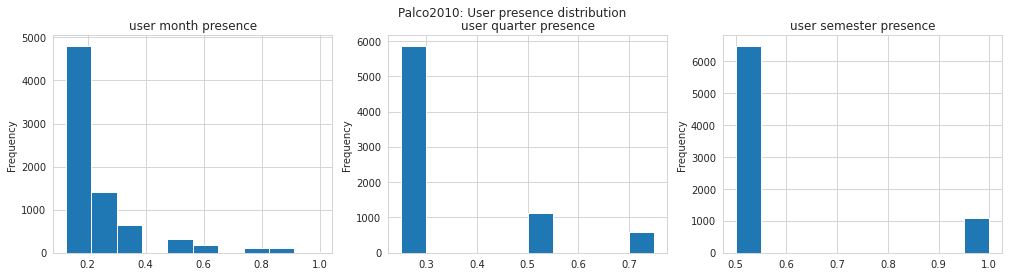

In [8]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name='Palco2010')

How many examples are there per quarter and semester?

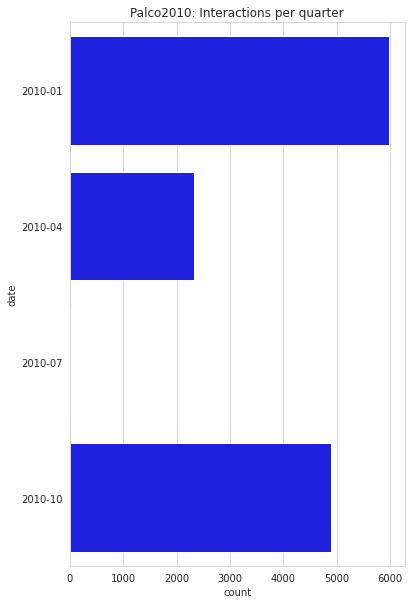

In [9]:
plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name='Palco2010', type_of_range='quarter')

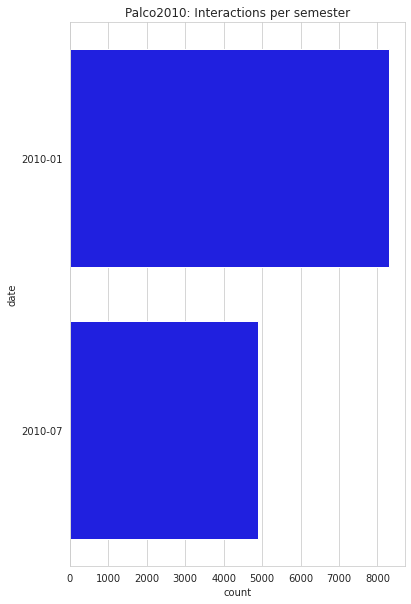

In [10]:
plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name='Palco2010', type_of_range='semester')

How many FREQUENT users (occur in 80% or more intervals) exist?

In [11]:
# defining threshold
frequency_threshold = 0.8

In [12]:
frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

109 users of 7580 (1.438%) occurr in 80.0% or more months.
0 users of 7580 (0.0%) occurr in 80.0% or more quarters.
1102 users of 7580 (14.538%) occurr in 80.0% or more semesters.


In median terms, how many times FREQUENT users appear in each quarter, and semester?

In [13]:
freq_user_quarter_info = get_frequent_user_statistics(
    interactions_df=user_trimestre_interactions, frequent_users_list=frequent_users_trimestre)
freq_user_quarter_info

,possible_holdout_users,median_freq_user_interactions
0,0,NaN
1,0,NaN
2,0,NaN
3,0,NaN


In [14]:
# # frequent user interaction per quarter
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions.loc[frequent_users_trimestre],
#     date_range=trimestres)

In [15]:
freq_user_semester_info = get_frequent_user_statistics(
    interactions_df=user_semestre_interactions, frequent_users_list=frequent_users_semestre)
freq_user_semester_info

,possible_holdout_users,median_freq_user_interactions
0,749,2.0
1,487,1.0


In [16]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions.loc[frequent_users_semestre], date_range=semestres, type_of_range='semester')

In [17]:
# these are the users that should be used in holdouts, and only their last interactions
# BUT, there are users that do not appear in some intervals, and some have only one interaction
user_trimestre_interactions.loc[frequent_users_trimestre]
user_semestre_interactions.loc[frequent_users_semestre];

#### Evaluating Interactions 50E3 sized Buckets 

In [18]:
n_iter_bucket = 50E3

interval_start, interval_end = get_bucket_intervals(data, n_iter_bucket)    

How many users per bucket?    

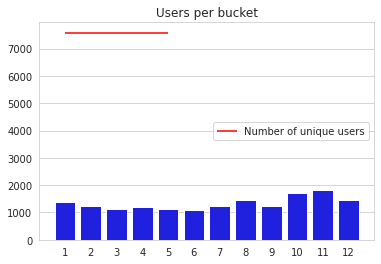

In [19]:
plot_users_per_fixed_bucket(data, 'user_id', interval_start, interval_end)

How many FREQUENT users (occur in 80% or more intervals) exist?

In [21]:
user_bucket_interactions_df, dates_fixed_buckets_df = get_fixed_buckets_info(data, 'user_id', interval_start, interval_end)

In [22]:
frequency_threshold

0.8

In [23]:
frequent_users_bucket = get_frequent_users_fixed_buckets(user_bucket_interactions_df, frequency_threshold)

147 users of 7580 (1.939%) occur in 80.0% or more buckets.


In median terms, how many times FREQUENT users appear in each bucket?

In [24]:
freq_user_bucket_info = get_frequent_user_statistics(user_bucket_interactions_df, frequent_users_bucket)
freq_user_bucket_info

,possible_holdout_users,median_freq_user_interactions
0,125,39.0
1,129,32.0
2,135,49.0
3,141,38.0
4,132,39.0
5,133,27.0
6,139,34.0
7,130,30.0
8,126,23.0
9,126,21.0


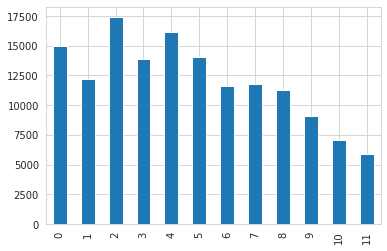

In [25]:
# frequent users interactions per bucket
plot_user_interactions_per_bucket(user_bucket_interactions_df, frequent_users_bucket)

Which timestamps occur in each bucket?

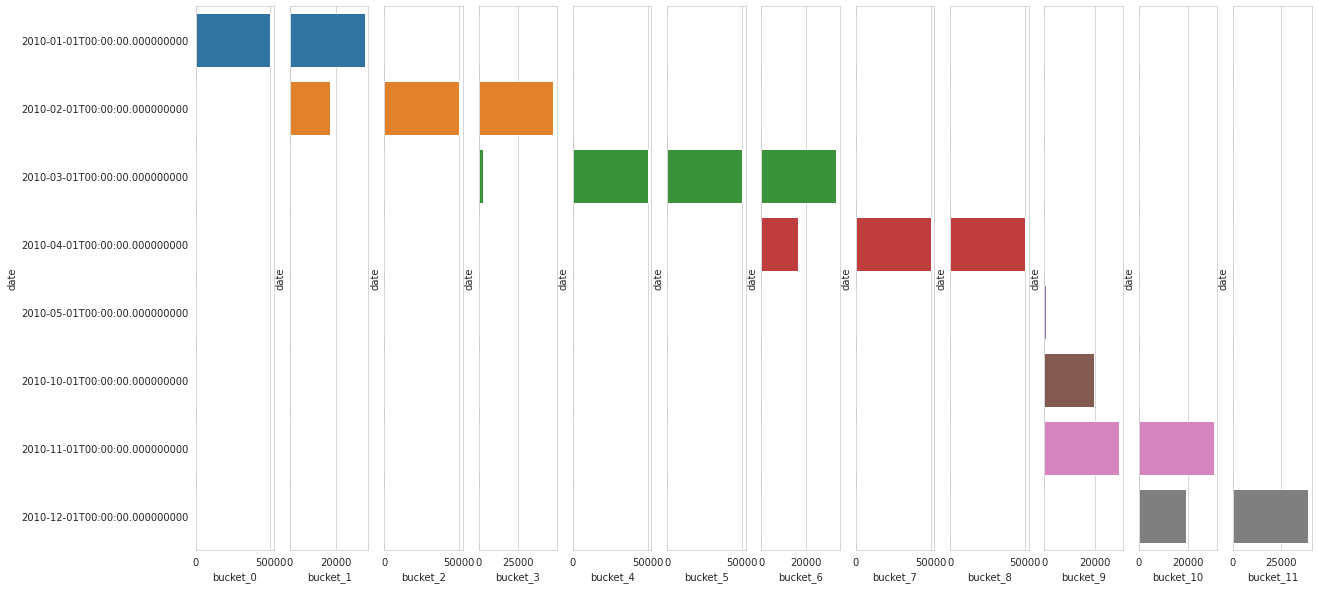

In [26]:
plot_timestamps_per_bucket(dates_fixed_buckets_df)

___

In [6]:
num_factors = 200
num_iter = 6
learn_rate = 0.35
regularization = 0.5
num_nodes = 8

In [7]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
# stream = ImplicitData(data['UserID'].to_list(), data['ItemID'].to_list())
stream = ImplicitData(data['user_id'], data['track_id'])

empty_stream = ImplicitData([], [])

In [8]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [9]:
# criamos instancia de EvaluateAndStore para criar holdouts com o método EvaluateAndStore
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_palco = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics=["Recall@N"], N_recommendations=20, seed=42)

In [10]:
# interações de 0 a 100 são usadas para pre treino. 
# count define numero de interações a serem usadas.
# holdouts e checkpoints são 
# store_only - somente guarda holdouts, não faz avaliação prequencial.
# default_user - Somente usado quando store_only = False durante avaliação prequencial.
_ = eval_palco.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 17 min

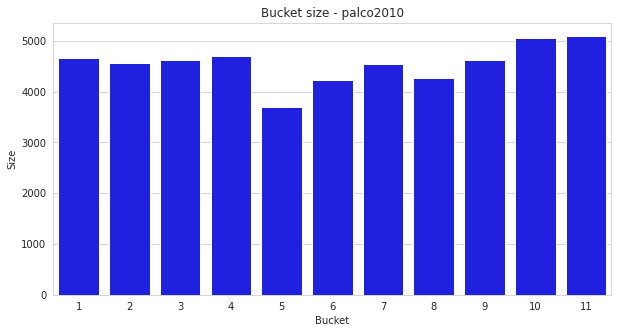

In [19]:
plot_bucket_size(eval_object=eval_palco, dataset_name='palco2010', filename='palco2010_bucket_size.png')

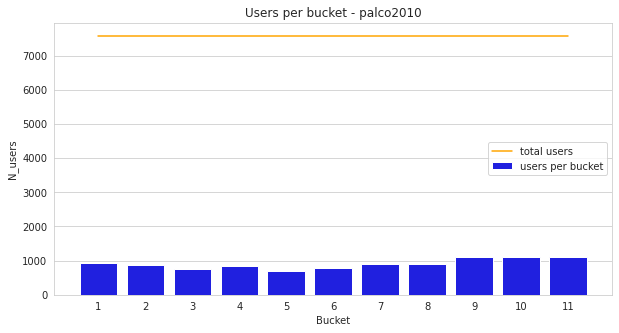

In [14]:
plot_n_users_per_bucket(eval_object=eval_palco, dataset_name='palco2010', filename='palco2010_user_per_bucket.png')

In [53]:
palco2010_ubm = get_bucket_map(eval_object=eval_palco)
palco2010_median_user_presence = median_user_presence_per_bucket(eval_object=eval_palco, user_bucket_map=palco2010_ubm)
print( palco2010_median_user_presence )
store_user_presence(dataset_name='palco2010',median_user_presence=palco2010_median_user_presence)

NameError: name 'eval_palco' is not defined

In [ ]:
joblib.dump(palco2010_ubm, 'output/joblib_bucket_info_dump/palco2010_ubm', compress=True)

['output/joblib_eval_objects_dump/palco2010_ubm']

___

___

In [ ]:
data = pd.read_csv("../datasets/ymusic_gte90_6kusers.tsv","\t")
stream = ImplicitData(data['user_id'],data['item_id'])
empty_stream = ImplicitData([], [])

In [ ]:
num_factors = 200
num_iter = 9
learn_rate = 0.25
regularization = 0.45
num_nodes = 16

In [ ]:
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_ymusic = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics = ["Recall@N"], N_recommendations=20, seed=42)

In [ ]:
_=eval_ymusic.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 42 min

In [ ]:
joblib.dump(eval_ymusic, 'output/joblib_bucket_info_dump/eval_ymusic', compress=True)

___
### Lastfm

In [ ]:
# importa dataset 'palco playlists'
data = pd.read_csv("../datasets/lastfm_50u.tsv","\t")

# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
stream = ImplicitData(data['user_id'], data['item_id'])

empty_stream = ImplicitData([], [])

In [ ]:
num_factors = 160
num_iter = 4
learn_rate = 0.5
regularization = 0.4
num_nodes = 8

In [ ]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_lastfm = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics = ["Recall@N"], N_recommendations=20, seed=42)

In [ ]:
_=eval_lastfm.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 441 min

In [ ]:
joblib.dump(eval_lastfm, 'output/joblib_bucket_info_dump/eval_lastfm', compress=True)

# Evaluation

In [ ]:
# def plot_n_users_per_bucket(eval_object:EvaluateAndStore, dataset_name:str, filename:str=None):
#     n_users = len( eval_object.data.userset )
#     n_users_bucket = pd.Series( [len( bucket.userset ) for bucket in eval_object.holdouts] )
#     n_users_bucket = n_users_bucket.reset_index()
#     n_users_bucket.columns = ['Bucket', 'N_users']
#     n_users_bucket['Bucket'] = n_users_bucket['Bucket']+1
#     plt.figure(figsize=(10,5))
#     sns.barplot(x='Bucket', y='N_users', data=n_users_bucket, color='b', label='users per bucket')
#     sns.lineplot(data=np.repeat(n_users, n_users_bucket.shape[0]), label='total users', color='orange')
#     plt.title(f'Users per bucket - {dataset_name}');
#     if filename:
#         plt.savefig(f'images/user_bucket_analysis/{filename}')

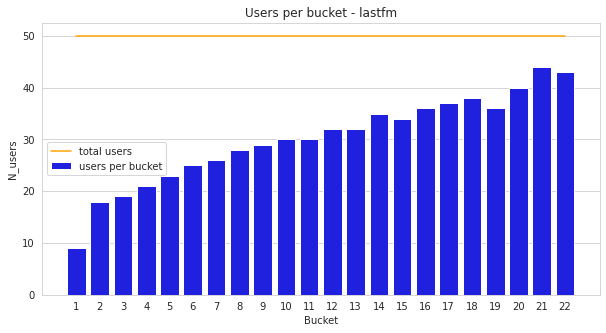

14.0

In [97]:
[bucket.userset for bucket in eval_lastfm.holdouts]

[array(['user_000174', 'user_000337', 'user_000407', 'user_000707',
        'user_000709', 'user_000751', 'user_000957', 'user_000984',
        'user_000986'], dtype='<U11'),
 array(['user_000019', 'user_000033', 'user_000174', 'user_000249',
        'user_000262', 'user_000267', 'user_000337', 'user_000390',
        'user_000407', 'user_000707', 'user_000709', 'user_000751',
        'user_000807', 'user_000882', 'user_000912', 'user_000957',
        'user_000984', 'user_000986'], dtype='<U11'),
 array(['user_000019', 'user_000033', 'user_000174', 'user_000249',
        'user_000262', 'user_000337', 'user_000374', 'user_000390',
        'user_000407', 'user_000707', 'user_000709', 'user_000751',
        'user_000767', 'user_000807', 'user_000882', 'user_000912',
        'user_000957', 'user_000984', 'user_000986'], dtype='<U11'),
 array(['user_000019', 'user_000033', 'user_000174', 'user_000249',
        'user_000262', 'user_000267', 'user_000330', 'user_000337',
        'user_000374',

In [43]:
plt.figure(figsize=(10,5))
sns.barplot(x='Bucket', y='N_users', data=n_users_bucket, color='b', label='users per bucket')
sns.lineplot(data=np.repeat(n_users, n_users_bucket.shape[0]), label='total users', color='orange');

3784